In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

In [458]:
# tree_1995 = pd.read_csv('../../data/external_data/2015_Street_Tree_Census_-_Tree_Data.csv')
awater = gpd.read_file("../../data/external_data/tl_2020_36_tract10/tl_2020_36_tract10.shp")
counties = ['36005', '36047', '36061', '36081', '36085']
mask = awater.GEOID10.str[:5].isin(counties)
awater = awater[mask]
# awater = awater[['GEOID10', 'geometry']]
# # make geometry from lat and lon
# from shapely.geometry import Point
# tree_1995['geometry'] = tree_1995.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
# # convert to geodataframe
# tree_1995 = gpd.GeoDataFrame(tree_1995, geometry='geometry')
# import tqdm.notebook as tqdm
# gids = pd.DataFrame(index=tree_1995.index, columns=['GEOID10'])
# for i in tqdm.tqdm(range(len(awater))):
#     # print(i)
#     poly = awater.iloc[i]['geometry']
#     mask = poly.contains(tree_1995['geometry'])
#     gids.loc[mask, 'GEOID10'] = awater.iloc[i]['GEOID10']
# tree_1995 = tree_1995.join(gids)
# tree_1995 = tree_1995.dropna(subset=['GEOID10'])
# tree_1995[['GEOID10']].groupby('GEOID10').size().to_csv('../../data/processed_data/tree_2015.csv')

In [459]:
# remove warning
pd.options.mode.chained_assignment = None

awater_df = awater[['GEOID10', 'ALAND10', 'AWATER10', 'geometry']]
awater_df['water_percentage'] = awater_df['AWATER10']/(awater_df['ALAND10'] + awater_df['AWATER10'])
awater_df['latitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.x,
    axis=1
)
awater_df['longitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.y,
    axis=1
)
C = 200
def app(row):
    lat_diff = awater_df['latitude'] - row.latitude
    long_diff = awater_df['longitude'] - row.longitude
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(-distance * C)
    weighted_exp_dist = exp_dist * awater_df['water_percentage']
    return weighted_exp_dist.sum() / exp_dist.sum()
awater_df['water_gaussian'] = awater_df.apply(
    lambda row: app(row),
    axis=1
)
awater_df = awater_df[['GEOID10', 'water_gaussian', 'water_percentage']]

In [460]:
tree_1995 = pd.read_csv('../../data/processed_data/tree_1995.csv')
tree_2015 = pd.read_csv('../../data/processed_data/tree_2015.csv')

In [461]:
# rename columns
tree_2015.columns = ['GEOID10', 'num_trees_2015']
tree_1995.columns = ['GEOID10', 'num_trees_1995']

In [462]:
tree_nyc = tree_2015.merge(tree_1995, on='GEOID10', how='inner')

In [463]:
tree_nyc.GEOID10 = tree_nyc.GEOID10.astype(str)
tree_nyc = tree_nyc.merge(awater_df, on='GEOID10', how='inner')

In [464]:
tree_nyc

,GEOID10,num_trees_2015,num_trees_1995,water_gaussian,water_percentage
0,36005000200,377,143,0.040486,0.647957
1,36005000400,455,108,0.042225,0.472666
2,36005001600,523,216,0.040873,0.000000
3,36005001900,507,155,0.046428,0.406110
4,36005002000,422,296,0.039938,0.000000
...,...,...,...,...,...
2129,36085030301,572,445,0.073660,0.000000
2130,36085030302,769,485,0.073234,0.000000
2131,36085031901,393,154,0.072683,0.000000
2132,36085031902,511,191,0.074511,0.298830


In [465]:
# from dbfread import DBF

# def convert_dbf_to_df(dbf_file_path):
#     dbf = DBF(dbf_file_path)
#     df = pd.DataFrame(iter(dbf))
#     return df
# pop_1995 = convert_dbf_to_df('../../data/external_data/STF3A_36.dbf') #[['TRACT', 'BLOCK', 'P0010001']]
# pop_1995.TRACT = pop_1995.TRACT.astype(float).astype(int).astype(str)
# pop_1995
# tree_nyc = tree_nyc.merge(pop_1995, left_on='GEOID10', right_on='TRACT', how='inner')

In [466]:
other_data = pd.read_csv('../../data/processed_data/data_nyc.csv')
print(other_data.columns)
misc_feats = other_data[['GEOID10_x', 'surface_temp', 'income_group', 'pop_dens_group', 'mean_percent_tree_cover']]

Index(['GEOID', 'mean_percent_tree_cover', 'tree_gap', 'surface_temp',
       'income_percent', 'income_group', 'pop_dens_group', 'GEOID10_x',
       'ALAND10', 'AWATER10', 'geometry', 'water_percentage', 'latitude',
       'longitude', 'water_gaussian', 'GEOID10_y',
       'avg_temp_reduction_tree_cover', 'annual_percent_runoff_reduction',
       'high_speed_street_bordered_tree_buffer', 'percent_residents_near_park',
       'percent_pm10_removed_trees', 'percent_tree_view',
       'percent_greenery_walkable_streets', 'NID', 'DwIndW', 'DwNIndW',
       'DwAvgW2', 'DwNAvgW2'],
      dtype='object')


In [467]:
misc_feats = misc_feats.rename(columns={'GEOID10_x': 'GEOID10'})
misc_feats.GEOID10 = misc_feats.GEOID10.astype(str)
misc_feats

,GEOID10,surface_temp,income_group,pop_dens_group,mean_percent_tree_cover
0,36085024800,28.773062,2.403846,2.673077,0.258494
1,36085025100,29.317413,3.000000,2.750000,0.157915
2,36085027301,28.408317,2.857143,2.928571,0.173566
3,36085027302,28.013129,2.387097,3.322581,0.180818
4,36085030301,30.450329,2.000000,3.689655,0.051182
...,...,...,...,...,...
2163,36081107202,NaN,NaN,NaN,NaN
2164,36081012500,28.606574,3.000000,3.777778,0.079528
2165,36081029400,30.355713,2.000000,3.426230,0.147562
2166,36081061301,29.283751,2.052632,3.736842,0.091592


In [468]:
# dtemp = pd.read_csv("../../data/processed_data/climate_change_tweets.csv")
# dtemp.drop(columns=['Unnamed: 0'], inplace=True)

# merged = pd.read_csv("../../data/processed_data/data_nyc.csv")
# merged.drop(columns=['GEOID'], inplace=True)
# # rename columns of merged 
# merged.rename(columns={'GEOID10_x': 'GEOID10'}, inplace=True)
# dtemp = dtemp[['temperature_avg', 'GEOID10']]
# dtemp = dtemp.groupby('GEOID10').mean()
# dtemp

In [469]:
tree_nyc = tree_nyc.merge(misc_feats, on='GEOID10', how='inner')

In [470]:
tree_nyc

,GEOID10,num_trees_2015,num_trees_1995,water_gaussian,water_percentage,surface_temp,income_group,pop_dens_group,mean_percent_tree_cover
0,36005000200,377,143,0.040486,0.647957,28.155665,1.619048,3.380952,0.150475
1,36005000400,455,108,0.042225,0.472666,28.368855,3.000000,3.192308,0.191821
2,36005001600,523,216,0.040873,0.000000,29.214966,1.071429,3.428571,0.163306
3,36005001900,507,155,0.046428,0.406110,30.535067,1.000000,3.357143,0.030956
4,36005002000,422,296,0.039938,0.000000,28.615701,1.000000,3.705882,0.204546
...,...,...,...,...,...,...,...,...,...
2129,36085030301,572,445,0.073660,0.000000,30.450329,2.000000,3.689655,0.051182
2130,36085030302,769,485,0.073234,0.000000,30.536584,2.000000,3.485714,0.184980
2131,36085031901,393,154,0.072683,0.000000,29.174923,1.000000,3.133333,0.318494
2132,36085031902,511,191,0.074511,0.298830,29.634628,1.291667,3.500000,0.328307


In [471]:
tree_nyc['tree_change'] = (tree_nyc['num_trees_2015'] - tree_nyc['num_trees_1995']) / tree_nyc['num_trees_1995']

(0.0, 10.0)

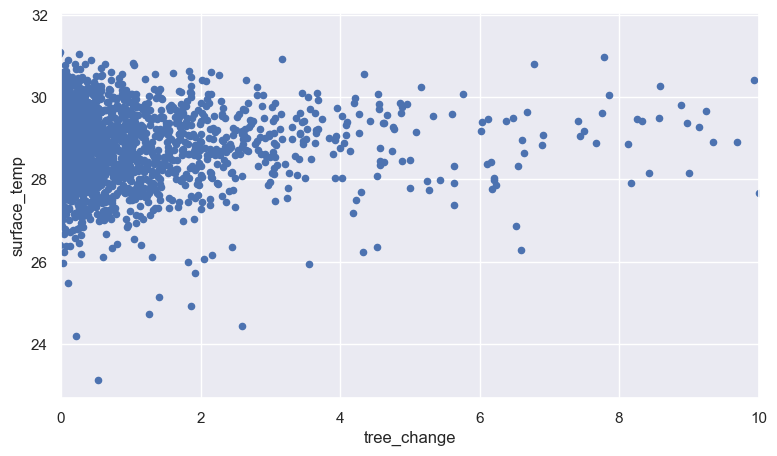

In [472]:
tree_nyc.plot.scatter(x='tree_change', y='surface_temp')
plt.xlim(0, 10)

In [473]:
tree_nyc.dropna(subset=['surface_temp'], inplace=True)

In [474]:
# do a linear regression with cross validation
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

formula = 'np.log(surface_temp) ~ water_gaussian + mean_percent_tree_cover + water_gaussian : mean_percent_tree_cover'

avg_train_r2 = 0
avg_test_r2 = 0

kf = KFold(n_splits=5, shuffle=True, random_state=i)
for train_index, test_index in kf.split(tree_nyc):
    train = tree_nyc.iloc[train_index]
    test = tree_nyc.iloc[test_index]
    model = OLS.from_formula(formula, data=train)
    result = model.fit()
    preds = result.predict(test)
    train_r2 = result.rsquared
    test_r2 = r2_score(test['surface_temp'], np.exp(preds))
    avg_train_r2 += train_r2
    avg_test_r2 += test_r2

avg_train_r2 / 5, avg_test_r2 / 5

(0.2656312042574268, 0.26452899988408063)

In [475]:
# do regression
import statsmodels.api as sm

formula = 'np.log(surface_temp) ~ water_gaussian * mean_percent_tree_cover'

ols = sm.OLS.from_formula(formula, data=tree_nyc)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(surface_temp)   R-squared:                       0.265
Model:                              OLS   Adj. R-squared:                  0.264
Method:                   Least Squares   F-statistic:                     254.1
Date:                  Sat, 11 Feb 2023   Prob (F-statistic):          8.15e-141
Time:                          18:22:37   Log-Likelihood:                 4401.0
No. Observations:                  2117   AIC:                            -8794.
Df Residuals:                      2113   BIC:                            -8771.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  3.4089      0.002   1623.107      0.000       3.405       3.413
water_gaussian                            -0.8583      0.042    -20.670      0.000      -0.940      -0.777
mean_percent_tree_cover                   -0.2072      0.012    -17.404      0.000      -0.231      -0.184
water_gaussian:mean_percent_tree_cover     2.0399      0.221      9.225      0.000       1.606       2.474
==============================================================================
Omnibus:                      128.659   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.146
Skew:                          -0.419   Prob(JB):                     3.94e-56
Kurtosis:                       4.480   Cond. No.                         342.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [476]:
# get concise summary as latex
from statsmodels.iolib.summary2 import summary_col
summ = summary_col([ols_result], stars=True, float_format='%0.3f', model_names=['OLS'], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)), 'R2': lambda x: "{:.3f}".format(x.rsquared)}).as_latex()
print(summ)
# ols_result.summary().as_latex()

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
                                           & OLS        \\
\hline
Intercept                                  & 3.409***   \\
                                           & (0.002)    \\
water\_gaussian                            & -0.858***  \\
                                           & (0.042)    \\
mean\_percent\_tree\_cover                 & -0.207***  \\
                                           & (0.012)    \\
water\_gaussian:mean\_percent\_tree\_cover & 2.040***   \\
                                           & (0.221)    \\
R-squared                                  & 0.265      \\
R-squared Adj.                             & 0.264      \\
N                                          & 2117       \\
R2                                         & 0.265      \\
\hline
\end{tabular}
\end{center}
\end{table}


<AxesSubplot: >

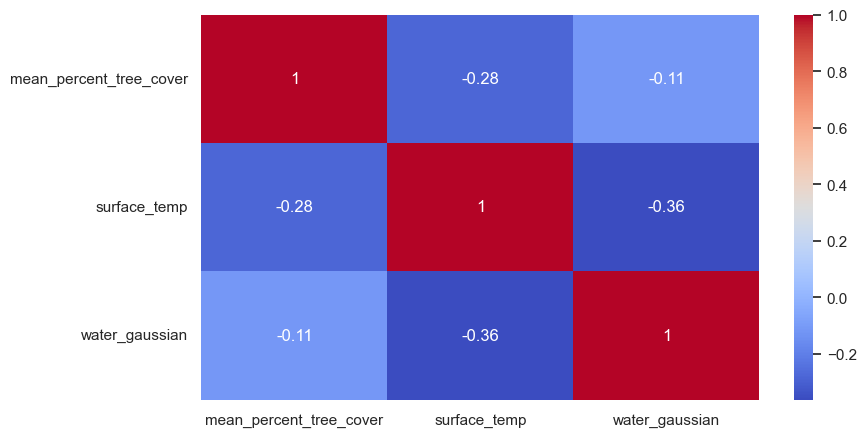

In [477]:
# sns corr
# set figure size
sns.set(rc={'figure.figsize':(9, 5)})
sns.heatmap(tree_nyc[['mean_percent_tree_cover', 'surface_temp', 'water_gaussian']].corr(), annot=True, cmap='coolwarm')

In [478]:
# ols results to latex


(-0.1, 0.1)

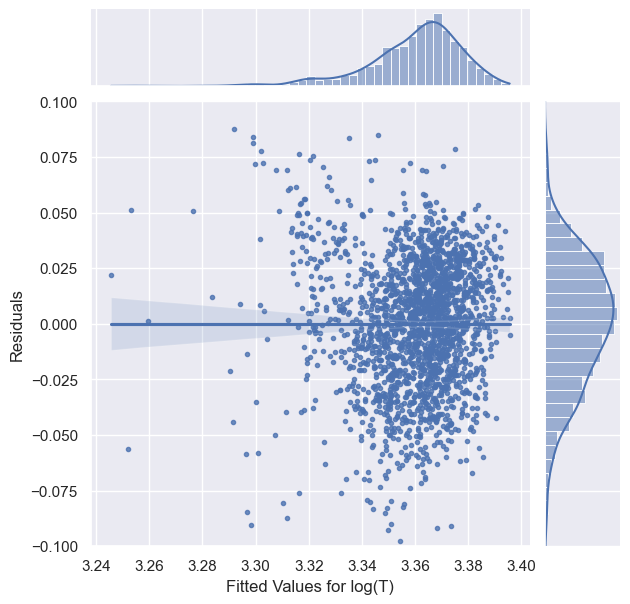

In [479]:
# plot the residuals using sns and hexbin
# fig, ax = plt.subplots(figsize=(15, 5))

# sns.jointplot(x=ols_result.fittedvalues, y=ols_result.resid, kind="hex", color="k", height=10)
sns.jointplot(x=ols_result.fittedvalues, y=ols_result.resid, kind="reg", color="b", marker='.')
plt.xlabel('Fitted Values for log(T)')
plt.ylabel('Residuals')
plt.ylim(-0.1, 0.1)

In [480]:
# get the coefficients
a0, a1, a2, a3 = ols_result.params

In [481]:
tree_nyc['t_grad_g'] = tree_nyc['surface_temp']*(a2 + a3 * tree_nyc['water_gaussian'])

In [482]:
# get geoids for the 10% of tracts with the highest negative temperature gradient
high_grad = tree_nyc.sort_values(by='t_grad_g', ascending=True).head(int(len(tree_nyc)*0.01))

In [483]:
#read pickle file
closest_geoids = pd.read_pickle('../../data/processed_data/dc_geoid_to_closest_geoids.p')
# convert dataframe to dictionary
# closest_geoids = closest_geoids.to_dict()
# convert keys to string
closest_geoids = {str(k): v for k, v in closest_geoids.items()}

In [484]:
geoid_temp = tree_nyc[['GEOID10', 'surface_temp']].set_index('GEOID10').to_dict()['surface_temp']

In [485]:
type(list(geoid_temp.keys())[0])

str

In [486]:
mins = []
maxs = []
for geoid, clst in closest_geoids.items():
    try:
        temps = [geoid_temp[str(geoid)] for geoid in clst]
        if geoid_temp[str(geoid)] <= min(temps):
            # print(geoid, geoid_temp[geoid], min(temps))
            mins.append(geoid)
        if geoid_temp[str(geoid)] >= max(temps):
            # print(geoid, geoid_temp[geoid], max(temps))
            maxs.append(geoid)
    except:
        pass
        # print(geoid, 'not in tree_nyc')

In [487]:
len(mins), len(maxs)

(152, 150)

In [488]:
s1 = set(high_grad['GEOID10'])
s2 = set(mins)
overlap = s1.intersection(s2)
len(s1), len(s2), len(overlap)

(21, 152, 0)

In [489]:
s1 = set(high_grad['GEOID10'])
s2 = set(maxs)
overlap = s1.intersection(s2)
len(s1), len(s2), len(overlap)

(21, 150, 6)

In [490]:
s3 = set(pd.read_csv("../../data/processed_data/low_tree_low_water.csv").columns)

In [491]:
len(s3.intersection(s1))

20

In [492]:
awater = awater.merge(tree_nyc, on='GEOID10', how='outer')

In [493]:
awater['t_grad_g'].fillna(0, inplace=True)

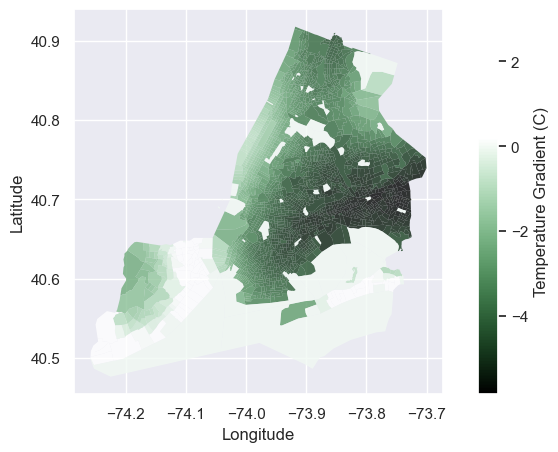

In [503]:
from matplotlib.colors import ListedColormap

# take first 4 colors from tab10
palette_tab10 = sns.color_palette("tab10", 10)
palette = sns.color_palette([palette_tab10[0], palette_tab10[2], palette_tab10[1], palette_tab10[3]])
my_cmap = ListedColormap(palette.as_hex())

cm = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1.5, reverse=True, as_cmap=True)

m = Basemap(llcrnrlon=-79, llcrnrlat=40.49, urcrnrlon=-71.96, urcrnrlat=45.01,
            resolution='i', projection='tmerc', lat_0=40.5, lon_0=-74.25)

awater.plot(column='t_grad_g', legend=True, ax=m.ax, edgecolor='none', alpha=0.8, cmap=cm, legend_kwds={'label': 'Temperature Gradient (C)'})

# add gridlines
sns.set(style="ticks")
sns.set_style("darkgrid")

plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [505]:
awater['at_risk'] = awater.GEOID10.apply(lambda x: 1 if x in high_grad['GEOID10'].values else 0)

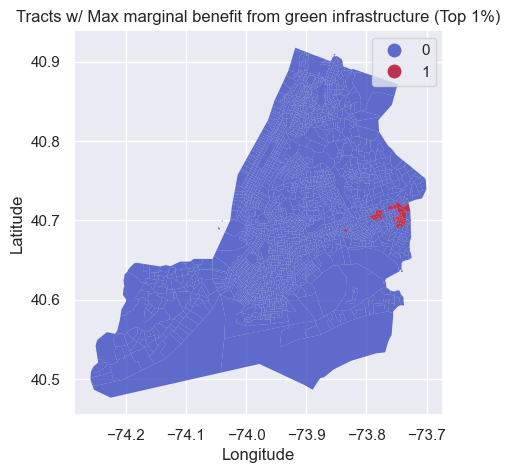

In [511]:
from matplotlib.colors import ListedColormap

# take first 4 colors from tab10
palette_tab10 = sns.color_palette("tab10", 10)
palette = sns.color_palette([palette_tab10[0], palette_tab10[2], palette_tab10[1], palette_tab10[3]])
my_cmap = ListedColormap(palette.as_hex())

m = Basemap(llcrnrlon=-79, llcrnrlat=40.49, urcrnrlon=-71.96, urcrnrlat=45.01,
            resolution='i', projection='tmerc', lat_0=40.5, lon_0=-74.25)

awater.plot(column='at_risk', legend=True, ax=m.ax, edgecolor='none', alpha=0.8, cmap='coolwarm', categorical=True)

# add gridlines
sns.set(style="ticks")
sns.set_style("darkgrid")

plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Tracts w/ Max marginal benefit from green infrastructure (Top 1%)')
plt.show()